# 1. Preparação de dados

## 1.1 Importando as bibliotecas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import f1_score,precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

## 1.2 Importando a base de dados eo dicionario

In [3]:
base = pd.read_csv('../data/raw/xAPI-Edu-Data.csv')
dicionario = pd.read_csv('../data/external/dicionario.csv')

## 1.3 Tratando os dados

### Tratamento de valores faltantes

A base de dados não tem valores faltantes

### Variável resposta

In [4]:
#Mapeando a variável resposta
base['StudentAbsenceDays'].replace({'Under-7':0,'Above-7':1},inplace=True)
base['StudentAbsenceDays'].head()

0    0
1    0
2    1
3    1
4    1
Name: StudentAbsenceDays, dtype: int64

### Variáveis explicativas

In [5]:
#Excluindo a linha da variávelaresposta no dicionário
dicionario.drop(index=15,
                axis=0,
                inplace= True)

In [6]:
#lista das variáveis quantitativas e qualitativas separadas em nominais e ordinais
lista_nominal = dicionario.query('Subtipo == "Nominal"')['Variavel'].to_list()
lista_ordinal = dicionario.query('Subtipo == "Ordinal"')['Variavel'].to_list()
lista_quantitativa = dicionario.query('Tipo == "Quantitativa"')['Variavel'].to_list()

nominal = Pipeline(steps=[
    ('encode',OneHotEncoder(sparse=False,handle_unknown = 'ignore')),
    ('normalizacao',StandardScaler())
])

ordinal = Pipeline(steps=[
    ('encode',OrdinalEncoder()),
    ('normalizacao',StandardScaler())
])

quantitativa = Pipeline(steps=[
    ('normalizacão',StandardScaler())
])

pre_processador_x = ColumnTransformer(transformers=[
    ('nominal',nominal,lista_nominal),
    ('ordinal',ordinal,lista_ordinal),
    ('quantitativa',quantitativa,lista_quantitativa)
])

# 2. Criando os modelos

## 2.1 Metodologia 

Nessa etapa será feita o treinamento dos modelos e sua seleção baseado em algumas métricas escolhidas. Os modelos utilizados serão os mostrados abaixo.

- Random Forest 
- Logistic Regresion 
- Support Vector Machine 
- Dummy Classifier

Haverá 3 etapas nesse processo. 

`Primeira etapa`: Será criado um modelo base para que seja usado como base para todos os outros modelos.

`Segunda etapa`: Será feito a modelagem com os modelos sem nenhuma edição 

`Terceira etapa`: Será feito um novo treinamento só que agora com escolha novos hiper parâmetros utilizando a técnica de Busca em Grade.


Ao fim das 3 etapas será analisado todas a soluções encontradas e selecionaremos os modelos usando métricas de validação abaixo. 

- Acurácia
- F1 score

## 2.2 Configurando o experimento

### Primeira etapa

Agora vamos criar o modelo base para toda a nossa análise. Todos os modelos subsequentes devem ser melhores doque este modelo.

In [7]:
#Criando o Pipeline para o modelo
model = Pipeline(steps=[
        ('preprocessamento',pre_processador_x),
        ('modelo',DummyClassifier())

    ])

#Fazendo a lista de métricas 
metricas = ['accuracy', 'f1']

#Fazendo o treianamento de validação cruzada 
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results = cross_validate(model, 
                         X = base.drop(columns=['StudentAbsenceDays']),
                         y = base['StudentAbsenceDays'],
                         cv = kfold,
                         scoring = metricas
                        )

#Mostrando as métricas
print(f"Acurácia: {results['test_accuracy'].mean()}\nF1 score: {results['test_f1'].mean()}")

Acurácia: 0.6020833333333333
F1 score: 0.0


Agora que sabemos valor do Modelo Base, vamos treinar os outros modelos para ser pelo menos maiores que o modelo base.

### Segunda etapa

In [8]:
#Criando a lista de modelos
lista_modelos = { 
    'Random Forest':RandomForestClassifier(),
    'Logistic Regression':LogisticRegression(),
    'Support Vector Machine':SVC()
}

#Fazendo a lista de métricas 
metricas = ['accuracy', 'f1']

#Criando um dataframe para guardar os resultados das métricas
resultados_etapa2 = pd.DataFrame(columns=['modelo', 'accuracy' ,'f1'])

#Treinando os modelos usando validação crusada de 10 divisões
for classificador in lista_modelos.keys():
    modelo = Pipeline(steps=[
        ('preprocessamento',pre_processador_x),
        ('modelo',lista_modelos[classificador])

    ])
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    results = cross_validate(modelo, 
                             X = base.drop(columns=['StudentAbsenceDays']),
                             y = base['StudentAbsenceDays'],
                             cv = kfold,
                            scoring = metricas
                            )
    lista_resultados = [str(classificador),
              results['test_accuracy'].mean(),
              results['test_f1'].mean()]
    resultados_etapa2.loc[len(resultados_etapa2)] = lista_resultados
    
    print(str(classificador).center(30,'='))

=========Random Tree==========
=====Logistic Regression======
====Support Vector Machine====


In [9]:
resultados_etapa2

,modelo,accuracy,f1
0,Random Tree,0.868750,0.818201
1,Logistic Regression,0.802083,0.745183
2,Support Vector Machine,0.822917,0.750576


[Text(0, 0, '0.8021'), Text(0, 0, '0.8229'), Text(0, 0, '0.8688')]

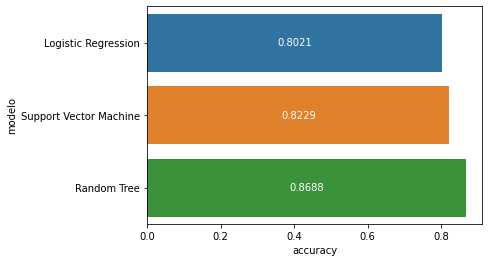

In [10]:
#Criando uma visualização
ax = sns.barplot(data=resultados_etapa2.sort_values('accuracy'),
            y='modelo',
            x='accuracy')

ax.bar_label(
    ax.containers[0],
    fmt='%.4f',
    label_type='center',
    color='white'

)

### Terceira etapa

In [11]:
#aqui vou criar a um dicionário com os paraemtros a semrem testados pelos modelos

lista_parametros = {
    'Random Forest':{
                   'modelo__n_estimators': range(2,20,5),
                   'modelo__max_features': ['sqrt', 'log2', None],
                   'modelo__max_depth': range(2,20,5),
                   'modelo__bootstrap': [True,False]
                  },
    'Logistic Regression':{
                            'modelo__solver':[ 'newton-cg', 'sag', 'saga'],
                            'modelo__C':[1.0, 0.1, 0.01],
                            'modelo__max_iter':[1000]
                          },
    'Support Vector Machine':{'modelo__C': [0.1, 1, 10, 100,], 
                              'modelo__gamma': [1, 0.1, 0.01,],
                              'modelo__kernel': ['linear', 'poly']
                             }
}

In [12]:
#Criando a lista de modelos
lista_modelos = { 
    'Random Forest':RandomForestClassifier(),
    'Logistic Regression':LogisticRegression(),
    'Support Vector Machine':SVC()
}

#Fazendo a lista de métricas 
metricas = ['accuracy', 'f1']

#Criando um dataframe para guardar os resultados das métricas
resultados_etapa3 = pd.DataFrame(columns=['modelo', 'parametros' ,'accuracy'])

#Treinando os modelos usando validação crusada de 10 divisões
for classificador in lista_modelos.keys():
    modelo = Pipeline(steps=[
        ('preprocessamento',pre_processador_x),
        ('modelo',lista_modelos[classificador])

    ])
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    results = GridSearchCV(estimator = modelo, 
                             param_grid = lista_parametros[classificador],
                             cv = kfold,
                             scoring = metricas,
                             refit = 'accuracy'
                            )
    results.fit(X = base.drop(columns=['StudentAbsenceDays']),
                y = base['StudentAbsenceDays'])

    
    
    lista_resultados = [str(classificador),
                        results.best_params_,
                        results.best_score_]
    resultados_etapa3.loc[len(resultados_etapa3)] = lista_resultados
    
    print(str(classificador).center(30,'='))

=========Random Tree==========
=====Logistic Regression======
====Support Vector Machine====


In [13]:
resultados_etapa3

,modelo,parametros,accuracy
0,Random Tree,"{'modelo__bootstrap': False, 'modelo__max_dept...",0.872917
1,Logistic Regression,"{'modelo__C': 0.1, 'modelo__max_iter': 1000, '...",0.820833
2,Support Vector Machine,"{'modelo__C': 0.1, 'modelo__gamma': 0.1, 'mode...",0.841667


[Text(0, 0, '0.8208'), Text(0, 0, '0.8417'), Text(0, 0, '0.8729')]

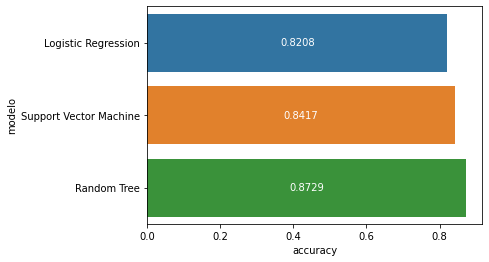

In [14]:
#Criando uma visualização
ax = sns.barplot(data=resultados_etapa3.sort_values('accuracy'),
            y='modelo',
            x='accuracy')

ax.bar_label(
    ax.containers[0],
    fmt='%.4f',
    label_type='center',
    color='white'

)

## 2.3 Resultados e discussão

Os modelos criados nas etapas 2 e 3 são melhores que o modelo base, contudo o não há grandes diferenças entre os modelos da segunda etapa e suas versões com hiper parâmetros diferentes da terceira etapa. Dito isso, pode-se escolher o modelo com maior acurácia da etapa 2 ou 3. Nesse caso irei selecionar o modelo Random Forest da etapa 2 como o melhor modelo.